## Codigo base

Se copio las lineas de codigo necesarias para poder hacer los ejercicios

In [1]:
import os
import tarfile
import urllib

import numpy as np
import pandas as pd
import sklearn

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Division del data set

Para esto, generamso una categoria con el ingreso medio para definir la proporcion de cada categoria

In [5]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [7]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Aca arrancamos con el train set

In [8]:
#housing = strat_train_set.copy() OPCION PARA VISUALIZAR DATOS JUNTO CON LAS ETIQUETAS
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [9]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_cat = housing[["ocean_proximity"]]

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

Let's create a custom transformer to add extra attributes:

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

'''
Esta es la manera de crear un transformador de datos "casero". Se puede 
crear uno de estos para cualquier transformacion que se le quiera hacer
a los datos y luego lo podemos poner en el proceso de nuestro pipeline
donde nos convenga.

'''

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Now let's build a pipeline for preprocessing the numerical attributes:

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

''' Pipeline:

Hay que generar instancias de cada etapa del pipeline y se coloca en 
el pipeline. Todos menos el ultimo deben ser transformers (deben tener 
el metodo fit_transform):

*Nombre del paso (no debe contener doble guionbajo, __)
*Estimador usado

'''
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

''' ColumnTransformer:

Nos sirve para manejar diferentes pipelines, que tienen diferentes tipos 
de datos en cada pipeline, sobre un mismo data set. Necesita 3 parametros:

*Nombre del paso (no debe contener doble guionbajo, __)
*Pipeline
*Etiquetas de las columnas dodne debe ser aplicado el transformador (en formato lista)

El Encoder devuelve una sparse matrix mientras que el num_pipeline devuelve una 
dense matrix. ColumnTransformer estima la densidad final de la matriz y 
devuelve una sparse matrix si se esta por debado del umbral de 0.3 (por default)

'''
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

## Ejercicio 1

Try a Support Vector Machine Regressor (sklearn.svm.SVR) with various huéráraeterts. such as kernel="linear" (with various values for C hyerparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don't wrry about what these hyperparameters mean for now. How does the best SVR predictor perform?

Hacer uso del grid search con svm. Costo, pero salio!

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
    {'kernel':['linear'],'C':[2,4,6]},
    {'kernel':['rbf'], 'C':[2,4,6]},
     'gamma': ['scale','auto'],
]

svm_reg = SVR()

grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [2, 4, 6], 'kernel': ['linear']},
                         {'C': [2, 4, 6], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [14]:
grid_search.best_params_

{'C': 6, 'kernel': 'linear'}

In [15]:
grid_search.best_estimator_

SVR(C=6, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [16]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

107136.26398576611 {'C': 2, 'kernel': 'linear'}
98407.97874755673 {'C': 4, 'kernel': 'linear'}
92217.5152955535 {'C': 6, 'kernel': 'linear'}
118352.3307726622 {'C': 2, 'gamma': 'scale', 'kernel': 'rbf'}
118356.69930471006 {'C': 2, 'gamma': 'auto', 'kernel': 'rbf'}
117780.30250426909 {'C': 4, 'gamma': 'scale', 'kernel': 'rbf'}
117802.52626179361 {'C': 4, 'gamma': 'auto', 'kernel': 'rbf'}
117230.84338987053 {'C': 6, 'gamma': 'scale', 'kernel': 'rbf'}
117253.23201932061 {'C': 6, 'gamma': 'auto', 'kernel': 'rbf'}


## Ejercicio 2

Try replacing GridSearchCV with RandomizedSearchCV

Hacer uso del random search. Vemos que con el grid search nos cuesta mucho encontrar rapidamente hiperparametros para optimizar el modelo. Vamos a hacer un random search con valores mucho mas altos.

Aurélien Géron utilizo distribuciones para realizar una mejor parametrización con el randomize search. Estas distribuciones se usan para hacer una busqueda de parametros mas optima. Pero yo como soy analfabeto del ML arranco con la manera facil.

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

''' PARAMETROS GENERADOS LINEALMENTE
C_range = list(range(6, 31))
C_values = C_range[::2]


param_distribs =[
    {'kernel':['linear'],'C':C_values},
    {'kernel':['rbf'], 'gamma': ['scale','auto'],'C':C_values},
]
'''

#PARAMETROS GENERADOS A PARTIR DE UNA DISTRIBUCION. MEJOR PARA UN R.S.

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error', 
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.4s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.6s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.1s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.1s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.0s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  10.1s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  10.7s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  11.1s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  49.8s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  38.3s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  47.8s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  41.9s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  33.4s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   6.3s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   6.6

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=   6.0s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  32.3s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  35.0s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  56.0s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  32.5s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  29.1s
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=   

[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  25.5s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  20.4s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   9.0s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   9.1s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   9.0s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   9.0s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   9.2s
[CV] C=399.7268155705

[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   5.2s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   5.0s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   5.1s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   8.0s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   8.2s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   8.1s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   8.3s
[CV] C=2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 55.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BE10607408>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BE10607748>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [19]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

In [20]:
rnd_search.best_estimator_

SVR(C=157055.10989448498, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params)

70487.7237017999 {'C': 629.782329591372, 'gamma': 3.010121430917521, 'kernel': 'linear'}
65152.0053324654 {'C': 26290.206464300216, 'gamma': 0.9084469696321253, 'kernel': 'rbf'}
100293.25860091094 {'C': 84.14107900575871, 'gamma': 0.059838768608680676, 'kernel': 'rbf'}
70574.10617249804 {'C': 432.37884813148855, 'gamma': 0.15416196746656105, 'kernel': 'linear'}
118838.9539854597 {'C': 24.17508294611391, 'gamma': 3.503557475158312, 'kernel': 'rbf'}
70029.31697470722 {'C': 113564.03940586245, 'gamma': 0.0007790692366582295, 'kernel': 'rbf'}
107662.7096409836 {'C': 108.30488238805073, 'gamma': 0.3627537294604771, 'kernel': 'rbf'}
77563.09297583395 {'C': 21.344953672647435, 'gamma': 0.023332523598323388, 'kernel': 'linear'}
62578.81054092114 {'C': 5603.270317432516, 'gamma': 0.15023452872733867, 'kernel': 'rbf'}
54767.960710084146 {'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}
70364.56459025714 {'C': 27652.464358739708, 'gamma': 0.2227358621286903, 'kernel': 'line

### Usp de distribuciones para determinacion de parametros con RandomizedSearchCV

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

In [22]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

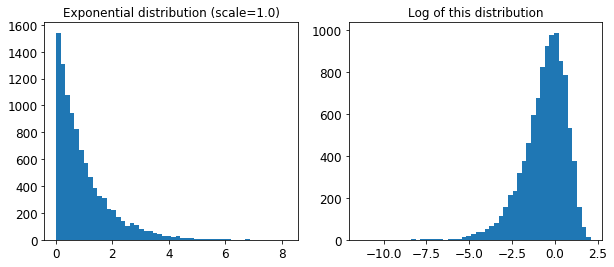

In [23]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

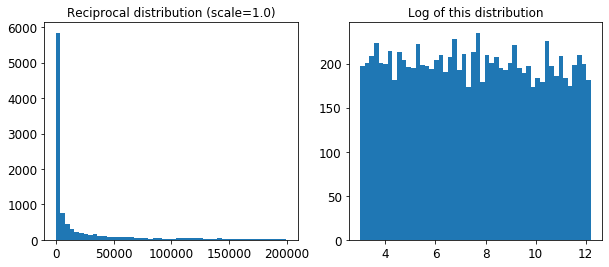

In [24]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## Ejercicio 3

Try adding transformer in the preparation pipeline to select only the most importan attributes.

Primero consigo the feature imporances

In [ ]:
feature_importances = rnd_search.best_estimator_.feature_importances_

Las miro y visualizo cuales son las mas importantes

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
zip(cat_one_hot_attribs, cat_attribs)

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

In [ ]:
def top(arr,k):
    np.sort()
    return 1

def bottom(arr,k):
    
    return 1

def top_bottom(arr,k):
    
    return 1

def indices_of_top_bottom_k(arr,k,t_b = 1)
    #t_b es un categorico que dice:
    #1: Se devuelve top k
    #2: Se devuelve bottom k
    #3: Se devuelve top y bottom k (k x 2 valores)
    
    switcher = {
        1: top,
        2: bottom,
        3: top_bottom
    }
    
    func = switcher.get(t_b, lambda: "Invalid Selection")
    
    return func(arr,k)
    
class MostImportantFeatureSelector(BaseEstimator, TransformerMinix):
    def __init__():
        
    def fit():
    
    def transform():

## Ejercicio 4

Try creating a simple pipeline that does the full data preparation plus the final prediction.

## Ejercicio 5

Automatically explore some preparation options using GridSearchCV.